### Q1

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [10]:
# 讀取訓練與測試資料
train_data = pd.read_csv('housing_5cities_train.csv')
test_data = pd.read_csv('housing_5cities_testa.csv')

# 提取特徵與目標變數
features = ['建物面積', '總樓層數', '屋齡', '縣市', '主要用途', '主要建材', '建物型態']
target = '單價'

X_train = train_data[features]
y_train = train_data[target]

# 特徵處理：對類別型特徵進行 OneHotEncode，對數值型特徵標準化
categorical_features = ['縣市', '主要用途', '主要建材', '建物型態']
numeric_features = ['建物面積', '總樓層數', '屋齡']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

# 建立 Ridge Regression 管道
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ridge', Ridge())])

# 設定 alpha 範圍
param_grid = {'ridge__alpha': np.logspace(-2, 2, 10)}

# 使用 GridSearchCV 來調整正則化參數
grid_search = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# 取得最佳模型與 alpha
best_ridge_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_['ridge__alpha']

In [11]:
# 在測試數據集上進行預測
X_test = test_data[features]
y_test = test_data[target]
y_pred = best_ridge_model.predict(X_test)

# 評估模型表現
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# 顯示模型評估結果
print(f'Best Alpha: {best_alpha}')
print(f'R2: {r2}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')

Best Alpha: 4.6415888336127775
R2: 0.6138289792153524
RMSE: 0.6508223189720618
MAE: 0.40180768796857647
MAPE: 19.19215355264237%


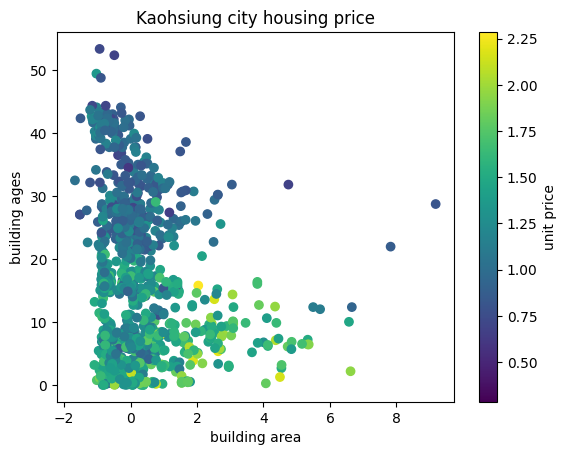

In [12]:
# 繪製高雄市資料點分布圖，依據單價進行上色
kaohsiung_data = train_data[train_data['縣市'] == '高雄市']
plt.scatter(kaohsiung_data['建物面積'], kaohsiung_data['屋齡'], c=kaohsiung_data['單價'], cmap='viridis')
plt.colorbar(label='unit price')
plt.xlabel('building area')
plt.ylabel('building ages')
plt.title('Kaohsiung city housing price')
plt.show()



1. **模型表現**：
   **R2**：0.613，表示模型能解釋約 61.3% 的變異，預測效果還算不錯，但仍有改善空間。
   **RMSE**：0.65，說明預測值和實際值之間的差異平均為 0.65 個單位價值。
   **MAE**：0.401，平均預測誤差約為 0.401，這也反映了模型的預測誤差。
   **MAPE**：19.19%，表示模型的平均百分誤差為 19.19%，即預測值與實際值的誤差在 20% 左右。

2. **高雄市房價資料點分布圖**：
   (1)大多數資料點集中在建物面積較小（主要在 0 到 4 之間）和屋齡較低（0 到 30 歲之間），這顯示高雄市的建物多數是相對年輕且建物面積較小的。
   (2)資料點的單價依據顏色進行區分，可以看到單價較高的建物（顏色偏黃綠）集中在建物面積相對較大或屋齡較新的區域。
   (3)屋齡較高（40 歲以上）的建物，單價較低（顏色偏藍），這符合一般情況，即老舊建物通常單價較低。

In [32]:
# 取得模型係數
ridge_model = best_ridge_model.named_steps['ridge']
preprocessor_model = best_ridge_model.named_steps['preprocessor']

# 反向轉換獲得特徵名稱
encoded_categories = preprocessor_model.transformers_[1][1].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, encoded_categories])

# 列出各個特徵的係數與常數項
coefficients = ridge_model.coef_
intercept = ridge_model.intercept_

# 打印結果
print(f'Best Alpha (Regularization Coefficient): {best_alpha:.4f}')
print(f'Intercept (Constant term coefficient): {intercept:.4f}')
for name, coef in zip(all_feature_names, coefficients):
    print(f'{name}: {coef:.4f}')

# 在測試集上進行預測
X_test = test_data[features]
y_test = test_data[target]
y_pred = best_ridge_model.predict(X_test)

# 計算評估指標
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# 顯示結果
print(f'R2: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.4f}')

Best Alpha (Regularization Coefficient): 4.6416
Intercept (Constant term coefficient): 1.9947
建物面積: 0.0062
總樓層數: 0.0378
屋齡: -0.1586
縣市_台中市: -0.4878
縣市_台北市: 1.6946
縣市_新北市: 0.1328
縣市_桃園市: -0.6263
縣市_高雄市: -0.7134
主要用途_一般事務所: 0.3586
主要用途_住商用: 0.1526
主要用途_住家用: 0.0104
主要用途_住工用: -0.0732
主要用途_其他: 0.0898
主要用途_商業用: 0.0101
主要用途_國民住宅: -0.2907
主要用途_工業用: 0.0354
主要用途_店鋪: -0.2267
主要用途_廠房: -0.0838
主要用途_辦公室: 0.0100
主要用途_集合住宅: 0.0076
主要建材_其他: 0.0652
主要建材_加強磚造: -0.0048
主要建材_磚造: -0.2081
主要建材_鋼筋混凝土加強磚造: 0.0677
主要建材_鋼筋混凝土造: -0.2365
主要建材_鋼骨造: 0.3165
建物型態_住宅大樓(11層含以上有電梯): 0.1196
建物型態_公寓(5樓含以下無電梯): -0.1414
建物型態_華廈(10層含以下有電梯): 0.0083
建物型態_透天厝: 0.0136
R2: 0.6138
RMSE: 0.6508
MAE: 0.4018
MAPE: 19.1922


### Q2

In [30]:
import pandas as pd
import numpy as np

# 讀取訓練資料
train_data = pd.read_csv('housing_5cities_train.csv')

# 過濾出高雄市的資料
kaohsiung_data = train_data[train_data['縣市'] == '高雄市']

# 計算 X 軸（橫坐標）和 Y 軸（縱坐標）的錨點座標（即高雄市的中心點）
anchor_x = kaohsiung_data['橫坐標'].mean()
anchor_y = kaohsiung_data['縱坐標'].mean()

# 計算 X 軸和 Y 軸的標準差
std_x = kaohsiung_data['橫坐標'].std()
std_y = kaohsiung_data['縱坐標'].std()

print(f'錨點座標: ({anchor_x:.4f}, {anchor_y:.4f})')
print(f'X 軸標準差: {std_x:.4f}')
print(f'Y 軸標準差: {std_y:.4f}')


錨點座標: (179372.9859, 2506459.4171)
X 軸標準差: 2314.8228
Y 軸標準差: 4033.3846


In [28]:
# 定義高斯基底函數 (GBF) 計算公式
def gaussian_basis_function(x_a, y_a, mu_x, mu_y, s_x, s_y):
    return np.exp(- ((x_a - mu_x) ** 2) / (2 * s_x ** 2) - ((y_a - mu_y) ** 2) / (2 * s_y ** 2))


In [31]:
# 使用 .copy() 創建副本，避免警告
kaohsiung_data = train_data[train_data['縣市'] == '高雄市'].copy()

# 計算 GBF 特徵值
kaohsiung_data['GBF特徵值'] = gaussian_basis_function(kaohsiung_data['橫坐標'], kaohsiung_data['縱坐標'], anchor_x, anchor_y, std_x, std_y)

# 列出高雄市 GBF 特徵值的統計量，並限制小數點至四位
kaohsiung_gbf_stats = kaohsiung_data['GBF特徵值'].describe(percentiles=[0.25, 0.5, 0.75])

# 將結果限制到小數點後四位
kaohsiung_gbf_stats = kaohsiung_gbf_stats.round(4)

print(kaohsiung_gbf_stats)

count    1067.0000
mean        0.5191
std         0.2927
min         0.0004
25%         0.2586
50%         0.5592
75%         0.7630
max         0.9944
Name: GBF特徵值, dtype: float64


In [37]:
import pandas as pd
import numpy as np

# 設定 K
K = 3

# 讀取訓練資料
train_data = pd.read_csv('housing_5cities_train.csv')

# 初始化一個字典來存儲每個縣市的錨點
anchor_points = {}

# 遍歷每個縣市，計算錨點
for city in train_data['縣市'].unique():
    city_data = train_data[train_data['縣市'] == city]
    
    # 找到 X 和 Y 軸的範圍
    x_min, x_max = city_data['橫坐標'].min(), city_data['橫坐標'].max()
    y_min, y_max = city_data['縱坐標'].min(), city_data['縱坐標'].max()
    
    # 將範圍切成 K 等分，計算每個子區間的長度
    x_step = (x_max - x_min) / K
    y_step = (y_max - y_min) / K
    
    # 存儲每個城市的錨點
    city_anchors = []
    
    for i in range(K):
        for j in range(K):
            x_start = x_min + i * x_step
            x_end = x_start + x_step
            y_start = y_min + j * y_step
            y_end = y_start + y_step
            
            # 找到這個子區間內的資料點
            grid_data = city_data[(city_data['橫坐標'] >= x_start) & (city_data['橫坐標'] < x_end) &
                                  (city_data['縱坐標'] >= y_start) & (city_data['縱坐標'] < y_end)]
            
            # 如果這個格子內的資料點數量超過 20，則計算均值和標準差作為錨點
            if len(grid_data) > 20:
                mu_x = grid_data['橫坐標'].mean()
                mu_y = grid_data['縱坐標'].mean()
                std_x = grid_data['橫坐標'].std()
                std_y = grid_data['縱坐標'].std()
                city_anchors.append((mu_x, mu_y, std_x, std_y))
    
    # 存儲結果
    anchor_points[city] = city_anchors

# 列出錨點
for city, anchors in anchor_points.items():
    print(f"{city} 的錨點數量：{len(anchors)}")
    for anchor in anchors:
        print(f"錨點位置：{anchor}")


台北市 的錨點數量：8
錨點位置：(300711.6666666667, 2768906.2666666666, 718.5568089166293, 534.0458213728881)
錨點位置：(301296.2397260274, 2772116.7191780824, 551.7597216279554, 1741.3430042717653)
錨點位置：(300595.4876033058, 2779851.0495867766, 1339.924886674016, 1610.8926606659204)
錨點位置：(304968.33720930235, 2768095.451162791, 1362.6245039281662, 1563.0305692936495)
錨點位置：(304675.44955752214, 2772124.585840708, 1447.1511116994275, 1477.7344320182192)
錨點位置：(303477.9583333333, 2778399.4375, 930.6354613317246, 1187.2550448496645)
錨點位置：(307985.6896551724, 2766744.4310344825, 514.5945502229665, 2023.7537218592736)
錨點位置：(309774.6971428571, 2773019.32, 1471.4744042426912, 1687.7133477868788)
高雄市 的錨點數量：8
錨點位置：(177731.806122449, 2502636.4081632653, 814.1717270940096, 1090.3848543768038)
錨點位置：(177477.6963788301, 2507344.1420612815, 781.1399024640127, 1645.701721375983)
錨點位置：(177080.3492063492, 2514791.698412698, 996.7211108741818, 1801.367765597276)
錨點位置：(180475.24528301886, 2502265.4088050313, 998.7640762271071, 167

In [34]:
# 計算 GBF 特徵
def compute_gbf_features(data, anchors):
    gbf_values = []
    for _, row in data.iterrows():
        gbf_row = []
        for (mu_x, mu_y, std_x, std_y) in anchors:
            gbf_value = np.exp(- ((row['橫坐標'] - mu_x) ** 2) / (2 * std_x ** 2) -
                                ((row['縱坐標'] - mu_y) ** 2) / (2 * std_y ** 2))
            gbf_row.append(gbf_value)
        gbf_values.append(np.mean(gbf_row))  # 平均值作為最終特徵
    return gbf_values

# 遍歷每個縣市，計算 GBF 特徵
train_data['GBF特徵'] = np.nan
for city, anchors in anchor_points.items():
    city_data = train_data[train_data['縣市'] == city]
    train_data.loc[train_data['縣市'] == city, 'GBF特徵'] = compute_gbf_features(city_data, anchors)

# 與第一題的特徵合併
features = ['建物面積', '總樓層數', '屋齡', '縣市', '主要用途', '主要建材', '建物型態', 'GBF特徵']
X_train = train_data[features]
y_train = train_data['單價']

# 使用與第一題類似的 Ridge Regression 模型
categorical_features = ['縣市', '主要用途', '主要建材', '建物型態']
numeric_features = ['建物面積', '總樓層數', '屋齡', 'GBF特徵']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ridge', Ridge())])

# 設定 alpha（正則化強度）的參數範圍
param_grid = {'ridge__alpha': np.logspace(-2, 2, 10)}

# 使用 GridSearchCV 來調整正則化參數
grid_search = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# 獲取最佳模型
best_ridge_model = grid_search.best_estimator_

# 預測測試集
test_data['GBF特徵'] = np.nan
for city, anchors in anchor_points.items():
    city_data = test_data[test_data['縣市'] == city]
    test_data.loc[test_data['縣市'] == city, 'GBF特徵'] = compute_gbf_features(city_data, anchors)

X_test = test_data[features]
y_test = test_data['單價']

y_pred = best_ridge_model.predict(X_test)

# 計算評估指標
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# 顯示結果
print(f'R2: {r2}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')


R2: 0.6231942086723213
RMSE: 0.642882172160833
MAE: 0.3935755255502746
MAPE: 18.688863969693177%
